In [ ]:
%matplotlib inline

In [1]:
import MDAnalysis as mda
import ARPDF, utils, search_boxes
import importlib
import matplotlib.pyplot as plt
import torch
from optimize_ARPDF import ARPDFOptimizer
import pandas as pd


importlib.reload(search_boxes)
importlib.reload(ARPDF)
importlib.reload(utils)
from ARPDF import *
from utils import *
from search_boxes import workflow_demo, search_structure

/opt/mamba/envs/arpdf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
u1, u2, modified_atoms, polar_axis = load_structure_data('data/CCl4')
X, Y = generate_grids(10, 256)
filter_fourier = lambda kX, kY, xp: xp.ones_like(kX)
print(modified_atoms)

[515, 516, 517, 518, 519, 645]


Using cupy to compute ARPDF...
Selected 461 atoms for universe 1, 477 atoms for universe 2.
Computing fields of universe 1...
Computed field for C-C: 118 atom pairs.
Computed field for C-CL: 679 atom pairs.
Computed field for CL-CL: 907 atom pairs.
Computing fields of universe 2...
Computed field for C-C: 118 atom pairs.
Computed field for C-CL: 674 atom pairs.
Computed field for CL-CL: 906 atom pairs.
Computing ARPDF...


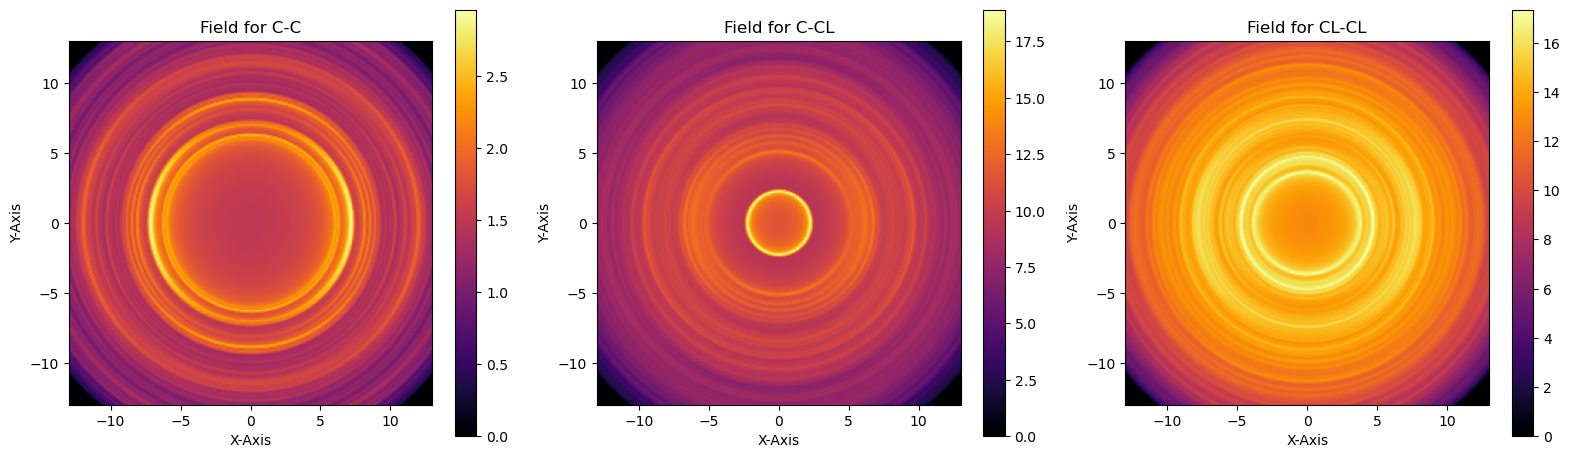

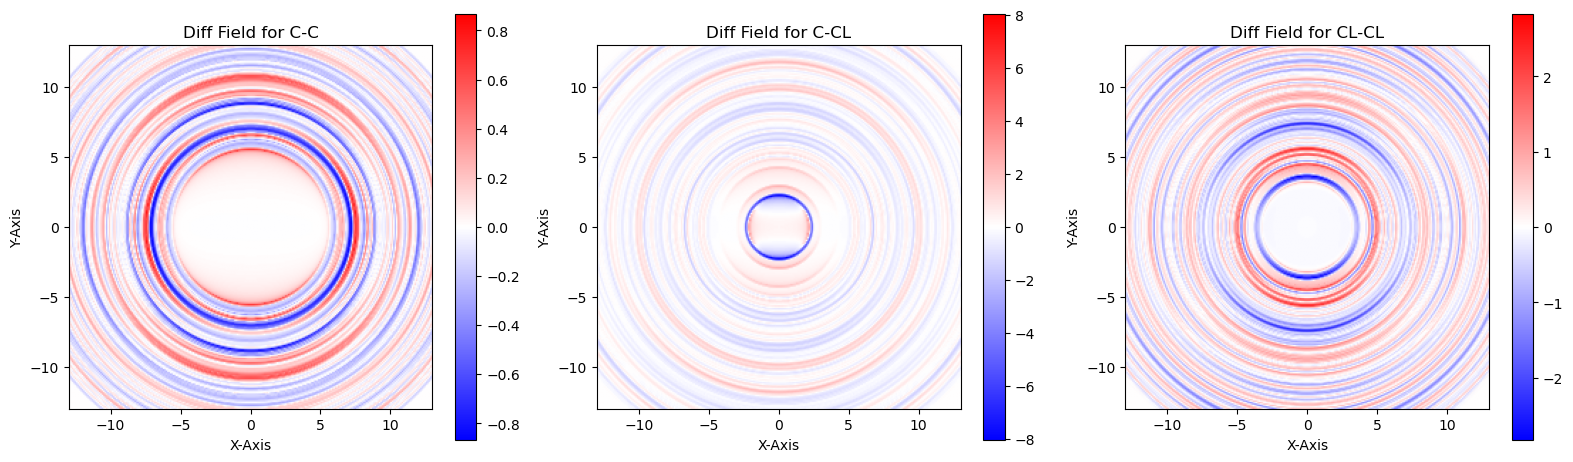

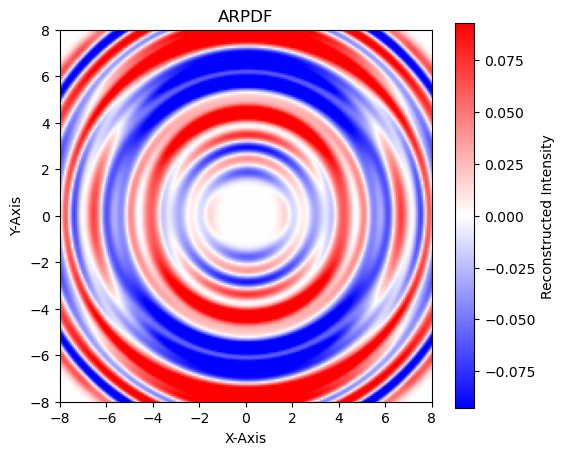

In [3]:
ARPDF_ref = compute_ARPDF(u1, u2, cutoff=13.0, N=512, grids_XY=(X, Y), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, filter_fourier=filter_fourier, verbose=True)

In [4]:
X_exp, Y_exp, ARPDF_exp = utils.load_exp_data('data/CCl4', rmax=10.0)

In [ ]:
def compare_slices_x_positive_y0(X_ref, Y_ref, ARPDF_ref,
                                  X_exp, Y_exp, ARPDF_exp,
                                  labels=("Sim", "Exp")):
    """
    Compare ARPDF slices at y=0 and x>0 from two datasets (ref and exp).
    """
    def _to_cpu(arr):
        return arr.get() if hasattr(arr, "get") else arr

    # 保证都在 CPU 上
    X_ref, Y_ref, A_ref = map(_to_cpu, (X_ref, Y_ref, ARPDF_ref))
    X_exp, Y_exp, A_exp = map(_to_cpu, (X_exp, Y_exp, ARPDF_exp))

    # 找出 y=0 最近的一行（横向切片）
    idx_y_ref = np.argmin(np.abs(Y_ref[:, 0]))  # y 是每一行值相同
    idx_y_exp = np.argmin(np.abs(Y_exp[:, 0]))

    # 获取 x>0 部分的切片
    x_ref = X_ref[idx_y_ref, :]
    slice_ref = A_ref[idx_y_ref, :]
    mask_ref = x_ref > 0
    x_ref = x_ref[mask_ref]
    slice_ref = slice_ref[mask_ref]

    x_exp = X_exp[idx_y_exp, :]
    slice_exp = A_exp[idx_y_exp, :]
    mask_exp = x_exp > 0
    x_exp = x_exp[mask_exp]
    slice_exp = slice_exp[mask_exp]

    # 画图
    plt.figure(figsize=(6, 4))
    plt.plot(x_ref, slice_ref*5.8, label=labels[0], lw=2)
    plt.plot(x_exp, slice_exp, label=labels[1], lw=2, linestyle="--")
    plt.xlabel("x (Å)")
    plt.ylabel("ARPDF at y = 0")
    plt.title("Comparison of ARPDF slices (y=0, x>0)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
compare_slices_x_positive_y0(X, Y, ARPDF_ref, X_exp, Y_exp, ARPDF_exp)


In [ ]:
def compare_slices_y_positive_x0(X_ref, Y_ref, ARPDF_ref,
                                  X_exp, Y_exp, ARPDF_exp,
                                  labels=("Sim", "Exp")):
    """
    Compare ARPDF slices at x=0 and y>0 from two datasets (ref and exp).
    """
    def _to_cpu(arr):
        return arr.get() if hasattr(arr, "get") else arr

    # 保证都在 CPU 上
    X_ref, Y_ref, A_ref = map(_to_cpu, (X_ref, Y_ref, ARPDF_ref))
    X_exp, Y_exp, A_exp = map(_to_cpu, (X_exp, Y_exp, ARPDF_exp))

    # 找出 x=0 最近的一列（纵向切片）
    idx_x_ref = np.argmin(np.abs(X_ref[0, :]))  # x 是每一列值相同
    idx_x_exp = np.argmin(np.abs(X_exp[0, :]))

    # 获取 y>0 部分的切片
    y_ref = Y_ref[:, idx_x_ref]
    slice_ref = A_ref[:, idx_x_ref]
    mask_ref = y_ref > 0
    y_ref = y_ref[mask_ref]
    slice_ref = slice_ref[mask_ref]

    y_exp = Y_exp[:, idx_x_exp]
    slice_exp = A_exp[:, idx_x_exp]
    mask_exp = y_exp > 0
    y_exp = y_exp[mask_exp]
    slice_exp = slice_exp[mask_exp]

    # 画图
    plt.figure(figsize=(6, 4))
    plt.plot(y_ref, slice_ref*5.8, label=labels[0], lw=2)
    plt.plot(y_exp, slice_exp, label=labels[1], lw=2, linestyle="--")
    plt.xlabel("y (Å)")
    plt.ylabel("ARPDF at x = 0")
    plt.title("Comparison of ARPDF slices (x=0, y>0)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
compare_slices_y_positive_x0(X, Y, ARPDF_ref, X_exp, Y_exp, ARPDF_exp)


In [ ]:
# --- 假设 ARPDF, ARPDF_ref, X, Y 都已经准备好 ---
# 如果是 cupy.ndarray，先转回 numpy
def to_cpu(a):
    return a.get() if 'cupy' in type(a).__module__ else a

ARPDF_ref = to_cpu(ARPDF_ref)
X          = to_cpu(X)
Y          = to_cpu(Y)

# 1. 找到最接近 y=0 的行索引
i0 = np.argmin(np.abs(Y[:, 0]))
print(f"y=0 切片行索引: {i0}, 实际 y={Y[i0,0]:.3f}")
i1 = np.argmin(np.abs(X[0, :]))
print(f"x=0 切片行索引: {i1}, 实际 x={X[0,i1]:.3f}")

# 2. 取出这一行的 x 坐标和两个 ARPDF 的值
x_line        = X[i0, :]
slice_ref     = ARPDF_ref[i0, :]
y_line        = Y[:,i1]
slice_ref1     = ARPDF_ref[:, i1]


# 3. 分为左右两部分
mask_pos = x_line > 0
mask_neg = y_line > 0

# 4. 作图
plt.figure(figsize=(6,4))

# 测试 vs 参考：右侧 (x>0)

plt.plot(x_line[mask_pos], slice_ref[mask_pos],  'x--', label='⊥')

# 测试 vs 参考：左侧 (x<0)

plt.plot(x_line[mask_neg], slice_ref1[mask_neg],  'd--', label='∥')

plt.axvline(0, color='k', lw=0.8, ls='--')
plt.xlabel('x (Å)')
plt.ylabel('ARPDF slice')
plt.title('ARPDF slice')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def plot_angular_distribution_quadrant1(ARPDF, X, Y, radii, tol=0.01):
    """
    Plot angular distribution (0–90°) from ARPDF at selected radii.
    """

    def _to_cpu(arr):
        return arr.get() if hasattr(arr, 'get') else arr

    AR = _to_cpu(ARPDF)
    Xc = _to_cpu(X)
    Yc = _to_cpu(Y)

    r_grid = np.sqrt(Xc**2 + Yc**2)
    theta_grid = np.arctan2(Yc, Xc)  # 弧度，[-pi, pi]

    if tol is None:
        unique_r = np.unique(np.round(r_grid.flatten(), 5))
        dr = np.min(np.diff(unique_r))
        tol = dr

    plt.figure(figsize=(6, 4))
    for r0 in radii:
        mask_r = np.abs(r_grid - r0) < tol
        mask_theta = (theta_grid >= 0) & (theta_grid <= np.pi / 2)
        mask = mask_r & mask_theta

        if not np.any(mask):
            print(f"⚠️ 无法在 r ≈ {r0} Å 且 θ ∈ [0°, 90°] 范围内找到点")
            continue

        theta_vals = theta_grid[mask]
        intensity_vals = AR[mask]
        theta_deg = theta_vals * 180.0 / np.pi
        order = np.argsort(theta_deg)
        plt.plot(theta_deg[order], intensity_vals[order], label=f"r ≈ {r0} Å")

    plt.xlabel('θ (degrees)')
    plt.ylabel('ARPDF')
    plt.title('Angular Distribution (0°–90°)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




In [ ]:
plot_angular_distribution_quadrant1(ARPDF_ref, X, Y, [1.9, 2.6, 3.0])


已生成过滤并重命名后的文件: data/CCl4/CCl4_clean.gro


/personal/ARPDF/search_boxes.py:191: UserWarning: Reader has no dt information, set to 1.0 ps
  pickle.dump(results, f)


Molecule 388: Similarity = 0.9680390794683732
Polar axis: [-0.54476255  0.6823893   0.48742038]
Modified atoms: [388]
[WORST] Molecule 569: Similarity = 0.131907808185848


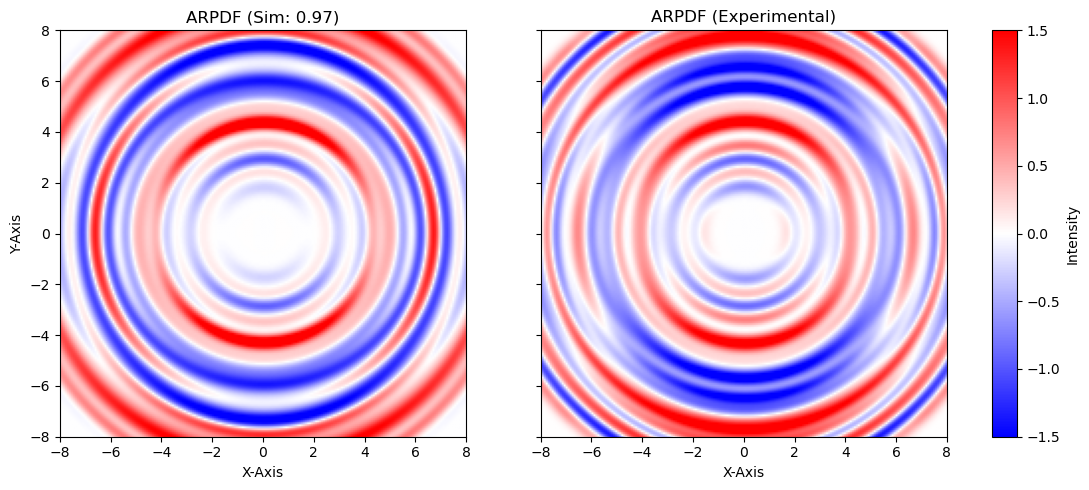

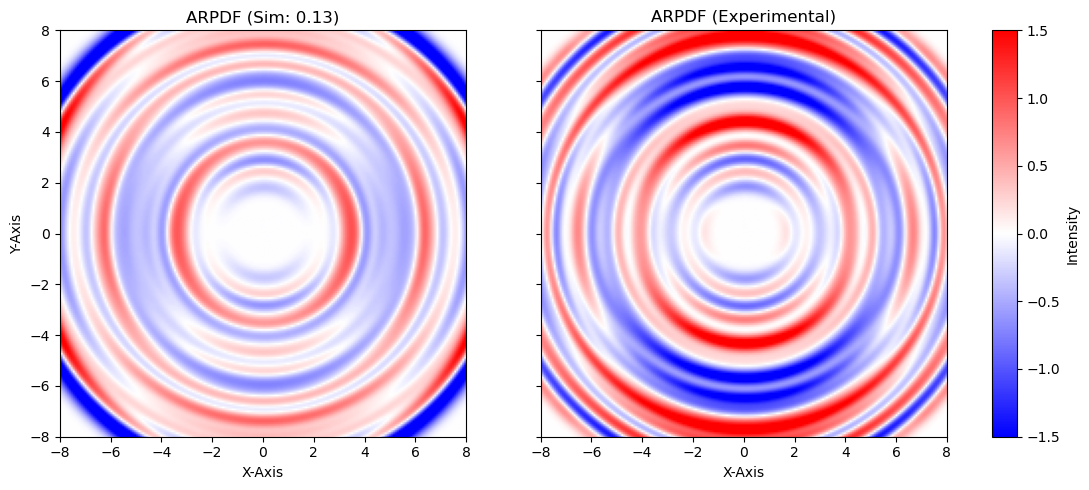

In [4]:
workflow_demo(X, Y, ARPDF_ref, filter_fourier, exp_name="exp8", metric="1D_average", weight_cutoff=5.0)

In [ ]:
u0 = mda.Universe('data/CCl4/CCl4.gro')
dir_name = "exp1"
device = torch.device('cuda')
ARPDF_optimizer = ARPDFOptimizer(
    X, Y, ARPDF_ref, Counter(u0.atoms.types), filter_fourier, cutoff=10.0, weight_cutoff=8.0,
    lr=0.01, gamma=0.995, f_lb=-0.9, s=0.0, beta=0.0, epochs=500, device=device
)
ARPDF_optimizer.set_system(cur_dir=f'tmp/{dir_name}')

In [ ]:
ARPDF_optimizer.optimize()

In [ ]:
df = pd.read_csv(f"tmp/{dir_name}/log.txt")
epochs = df['epoch'].values
loss = df['loss'].values
cos_sim = df['cos_sim'].values
line1, = plt.plot(epochs, loss, label='Loss')
plt.xlabel('Epoch')
plt.twinx()
line2, = plt.plot(epochs, cos_sim, label='Cosine Similarity', color='red')
plt.ylabel('Cosine Similarity')
plt.legend([line1, line2], ['Loss', 'Cosine Similarity'], loc='upper right')
plt.title('Optimization Progress')
plt.show()

In [ ]:
u1, u2, modified_atoms, polar_axis = utils.load_structure_data(f'tmp/{dir_name}')
polar_axis = np.array(polar_axis)
polar_axis /= np.linalg.norm(polar_axis)
# u2 = mda.Universe('tmp/cos_sim/CCl4_best_init.gro')
trajs = np.load(f"tmp/{dir_name}/traj.npy")[::5]

def rotation_matrix(v1, v2):
    u = v1 - v2
    if np.linalg.norm(u) < 1e-8:
        return np.eye(3)
    u /= np.linalg.norm(u)
    return np.eye(3) - 2 * np.outer(u, u)

R = rotation_matrix(polar_axis, np.array([0., 0., 1.]))
center_group = u2.atoms[modified_atoms]
_center = center_group[0].position[None, :]
around_group = u2.select_atoms("around 6.0 group center", center = center_group, periodic=True)
center_group.positions = utils.box_shift(center_group.positions - _center, u2.dimensions) @ R.T
around_group.positions = utils.box_shift(around_group.positions - _center, u2.dimensions) @ R.T
trajs = utils.box_shift(trajs - _center[None, :, :], u2.dimensions) @ R.T
full_trajs = np.zeros((trajs.shape[0], center_group.n_atoms + around_group.n_atoms, 3))
full_trajs[:, :center_group.n_atoms, :] = trajs
full_trajs[:, center_group.n_atoms:, :] = around_group.positions[None, :, :]
u_new = mda.Merge(center_group, around_group)
u_new.load_new(full_trajs[1:], format="memory", dt=1.0)
# print(around_group.positions[:5])
with mda.Writer(f"tmp/{dir_name}/traj.xyz", center_group.n_atoms + around_group.n_atoms) as W:
    for ts in u_new.trajectory:
        W.write(u_new.atoms)